In [1]:
import pandas as pd
import requests
import datetime
from bs4 import BeautifulSoup
import json
import math

Le fichier est fourni au format txt

Nom et Prénom - Longueur : 80 - Position : 1-80 - Type : Alphanumérique
La forme générale est NOM*PRENOMS

Sexe - Longueur : 1 - Position : 81 - Type : Numérique
1 = Masculin; 2 = féminin

Date de naissance - Longueur : 8 - Position : 82-89 - Type : Numérique
Forme : AAAAMMJJ - AAAA=0000 si année inconnue; MM=00 si mois inconnu; JJ=00 si jour inconnu

Code du lieu de naissance - Longueur : 5 - Position : 90-94 - Type : Alphanumérique
Code Officiel Géographique en vigueur au moment de la prise en compte du décès

Commune de naissance en clair - Longueur : 30 - Position : 95-124 - Type : Alphanumérique

DOM/TOM/COM/Pays de naissance en clair - Longueur : 30 - Position : 125-154 - Type : Alphanumérique

Date de décès - Longueur : 8 - Position : 155-162 - Type : Numérique
Forme : AAAAMMJJ - AAAA=0000 si année inconnue; MM=00 si mois inconnu; JJ=00 si jour inconnu

Code du lieu de décès - Longueur : 5 - Position : 163-167 - Type : Alphanumérique
Code Officiel Géographique en vigueur au moment de la prise en compte du décès

Numéro d'acte de décès - Longueur : 9 - Position : 168-176 - Type : Alphanumérique

In [2]:
url = "https://www.data.gouv.fr/fr/datasets/fichier-des-personnes-decedees/"
soup = BeautifulSoup(requests.get(url).content)
ld_json=soup.find('script', {'type':'application/ld+json'}).contents
data=json.loads(ld_json[0])
deces_url={}
for d in data['distribution']:
    deces_url.update({d['name']:d['url']})
deces_url

{'deces-2020-t2.txt': 'https://www.data.gouv.fr/fr/datasets/r/f3fc66ec-bd2c-42e9-af3f-73fc045571e6',
 'deces-2020-m06.txt': 'https://www.data.gouv.fr/fr/datasets/r/189a32ae-2960-48e2-b720-0ba933a58825',
 'deces-2020-m05.txt': 'https://www.data.gouv.fr/fr/datasets/r/0190fb90-fb7c-4626-9e49-ba10f751919c',
 'deces-2020-m04.txt': 'https://www.data.gouv.fr/fr/datasets/r/4e68eff8-3b1f-44c9-9cac-bc29daa95199',
 'deces-2020-t1.txt': 'https://www.data.gouv.fr/fr/datasets/r/54ffc97f-4d9b-4ce0-acdf-63d5526dfbd8',
 'deces-2020-m03.txt': 'https://www.data.gouv.fr/fr/datasets/r/74e3aa63-8cd5-4cfd-8c24-892d9eb4f636',
 'deces-2020-m02.txt': 'https://www.data.gouv.fr/fr/datasets/r/d0ff63f9-455f-4766-b7cf-58de45dfc8c4',
 'deces-2020-m01.txt': 'https://www.data.gouv.fr/fr/datasets/r/527ba187-2dbc-4c6a-b599-835e728d606f',
 'deces-2019.txt': 'https://www.data.gouv.fr/fr/datasets/r/02acf8f5-9190-4f8e-a37c-3b34eccac833',
 'deces-2019-t4.txt': 'https://www.data.gouv.fr/fr/datasets/r/0a649877-332b-4901-824d-e5

In [3]:
#d=requests.get('https://www.data.gouv.fr/fr/datasets/r/f3fc66ec-bd2c-42e9-af3f-73fc045571e6')
d={}
for i in ['2000','2001','2002','2003','2004','2005','2020-t1','2020-t2']:
    d.update({i:requests.get(deces_url['deces-'+i+'.txt'])})

In [5]:
d={}
for i in ['2019','2018','2020-t1','2020-t2']:
    d.update({i:requests.get(deces_url['deces-'+i+'.txt'])})

In [120]:
for i in ['2018']:
    d.update({i:requests.get(deces_url['deces-'+i+'.txt'])})

In [6]:
list(d.keys())

['2019', '2018', '2020-t1', '2020-t2']

In [7]:
pdict={}

def string_to_date(s):
    y=int(s[0:4])
    m=int(s[4:6])
    d=int(s[6:8])
    if m==0:
        m=1
    if d==0:
        d=1
    if y==0:
        raise ValueError
    try:
        date=datetime.date(y,m,d)
    except:
        if m==2 and d==29:
            d=28
            date=datetime.date(y,m,d)
            raise ValueError
    return date

for i in list(d.keys()):
    data=[]

    for l in d[i].text.splitlines():
        [last_name,first_name]=(l[0:80].split("/")[0]).split("*")
        sex=int(l[80])
        birthlocationcode=l[89:94]
        birthlocationname=l[94:124].rstrip()
        try:
            birthdate=string_to_date(l[81:89])
            deathdate=string_to_date(l[154:].strip()[0:8]) # sometimes, heading space
            lbis=list(l[154:].strip()[0:8])
            lbis[0:4]=list('2003')
            lbis=''.join(lbis)
            deathdatebis=string_to_date(lbis)
        except ValueError:
            if lbis!='20030229':
                print(l,lbis)
        deathlocationcode=l[162:167]
        deathid=l[167:176]
        data.append([first_name,last_name,sex,birthdate,birthlocationcode,birthlocationname,deathdate,deathlocationcode,deathid,deathdatebis,1])
    p=pd.DataFrame(data)
    p.columns=['first_name','last_name','sex','birth_date','birth_location_code','birth_location_name','death_date','death_location_code','death_id','death_date_bis','i']
    p["age"]=[k.days/365 for k in p["death_date"]-p["birth_date"]]
    p["age_class"]=[math.floor(k/20) for k in p["age"]]
    pdict.update({i:p})

AKO*AMAFFE ROGER/                                                               10000000099326EBIMPE                        COTE D'IVOIRE                 2019061594043444                             20030616
NGUYEN*THI NAM/                                                                 20000000099243VINH BINH                     VIET NAM                      2009062695277302                             20030303


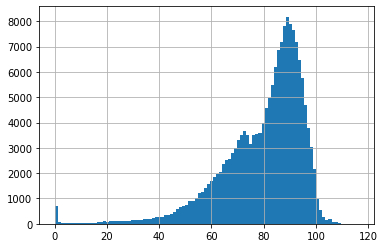

In [21]:
pdict["2020-t1"]["age"].hist(bins=100)

In [49]:
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

# Canicule 2003

2003
2000
2001
2002
2004
2005


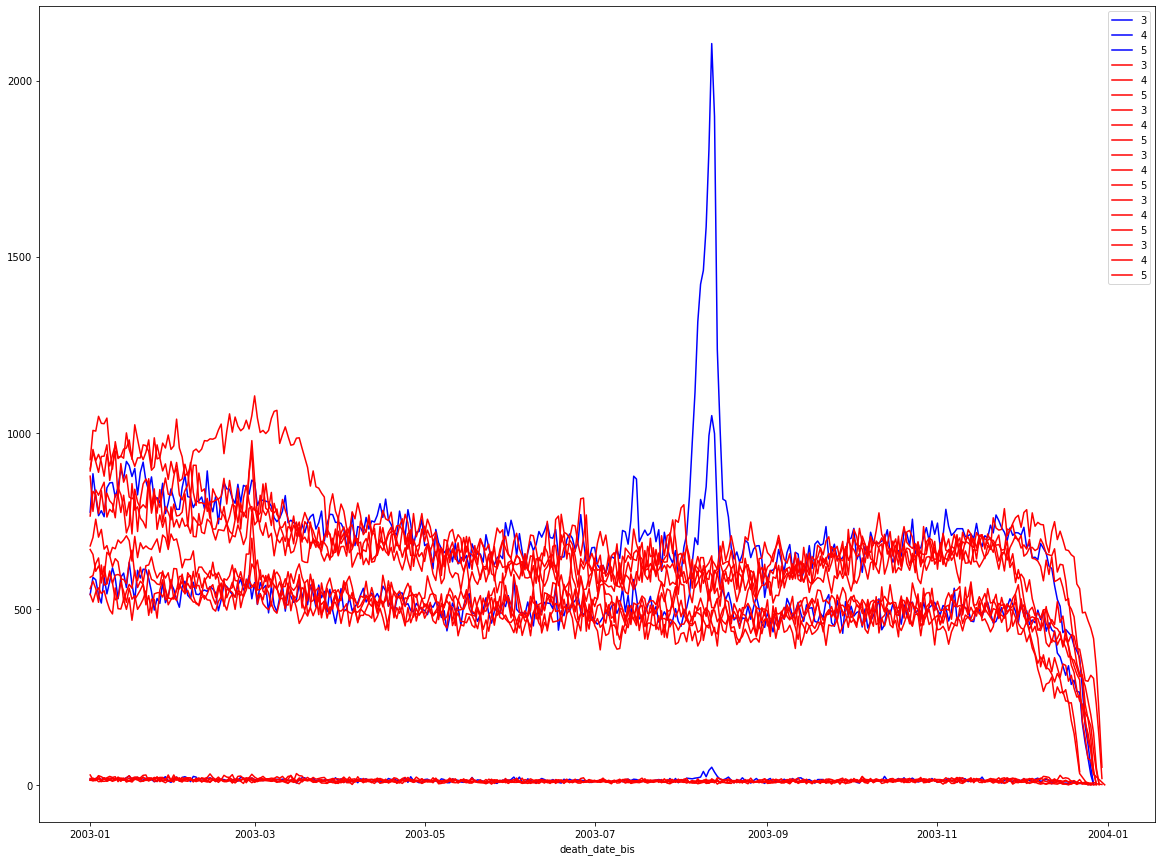

In [22]:
a={}
b={}
for y in [2003,2000,2001,2002,2004,2005]:
    print(y)
    s2=pdict[str(y)][(pdict[str(y)]["death_date"]>=datetime.date(y,1,1)) & (pdict[str(y)]["age_class"]>2)].groupby(['death_date_bis']).age_class.value_counts()
    if y==2003:
        ax=s2.unstack().plot(figsize=(20,15),color='blue',label=str(y))
    else:
        s2.unstack().plot(ax=ax,color='red')
    a[y]=pdict[str(y)][(pdict[str(y)]["death_date_bis"]>=datetime.date(2003,8,1)) & \
                       (pdict[str(y)]["death_date_bis"]<datetime.date(2003,8,19)) & \
                       (pdict[str(y)]["age_class"]>2)].groupby(['death_date_bis']).age_class.value_counts().sum()
    b[y]=pdict[str(y)][(pdict[str(y)]["death_date_bis"]>=datetime.date(2003,9,1)) & \
                       (pdict[str(y)]["death_date_bis"]<datetime.date(2003,12,1)) & \
                       (pdict[str(y)]["age_class"]>2)].groupby(['death_date_bis']).age_class.value_counts().sum()

In [20]:
print(a,b)

{2003: 34290, 2000: 20727, 2001: 21267, 2002: 19999, 2004: 19741, 2005: 19365} {2003: 111935, 2000: 116928, 2001: 113489, 2002: 109725, 2004: 106997, 2005: 106879}


In [30]:
import numpy as np
ete2003=a[2003]
ete=np.array([a[y] for y in [2000,2001,2002,2004,2005]])
aut2003=b[2003]
aut=np.array([b[y] for y in [2000,2001,2002,2004,2005]])

In [32]:
(ete2003-ete.mean())/ete.std()

20.468848347613466

In [38]:
(aut2003-aut.mean())/aut.std()

0.29062713089944453

In [39]:
(aut2003-aut.mean())

1131.3999999999942

In [37]:
math.sqrt(ete.mean())

142.19634313160097

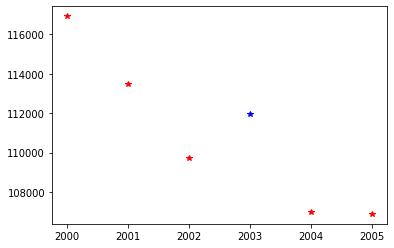

In [42]:
import matplotlib.pyplot as plt
plt.plot([2000,2001,2002,2004,2005],aut,'*r',2003,aut2003,'*b')

# Covid19 - S1 de 2020

In [8]:
import sys
sys.path.insert(1, '..')
from importlib import reload
from cocoa.cocoa import * 

In [9]:
listwhich()

['deaths', 'confirmed', 'recovered']

In [72]:
help(get)

Help on function get in module cocoa.cocoa:

get(**kwargs)
    Return covid19 data in specified format output (default, by list) 
    for specified locations ('where' keyword). 
    The used database is set by the setbase() function but can be
    changed on the fly ('whom' keyword)
    
    Keyword arguments
    -----------------
    
    where  --   a single string of location, or list of (mandatory, 
                no default value)
    what   --   what sort of data to deliver ( 'death','confirmed',
                'recovered' …). See listwhat() function for full
                list according to the used database.
    which  --   which data are computed, either in cumulative mode 
                ( 'cumul', default value) or 'daily' or other. See 
                listwhich() for fullist of available 
                Full list of which keyword with the listwhich() function.
    whom   --   Database specification (overload the setbase() 
                function). See listwhom() for

In [10]:
pc=get(where='France',what='Diff',which='deaths',output='pandas')
pc.head()

,country,date,cases
0,FRA,2020-01-22,0
1,FRA,2020-01-23,0
2,FRA,2020-01-24,0
3,FRA,2020-01-25,0
4,FRA,2020-01-26,0


In [11]:
p2020=pdict["2020-t2"].append(pdict["2020-t1"])
p2019=pdict["2019"]
p2018=pdict["2018"]

p2019["death_date_bis"]=[datetime.date(2020,y.month,y.day) for y in p2019["death_date"]]
p2018["death_date_bis"]=[datetime.date(2020,y.month,y.day) for y in p2018["death_date"]]
p2020["death_date_bis"]=p2020["death_date"]

p2018.head()

,first_name,last_name,sex,birth_date,birth_location_code,birth_location_name,death_date,death_location_code,death_id,death_date_bis,i,age,age_class
0,FRANCOIS,GOUSSEF,1,1941-11-04,01386,SAINT-SORLIN-EN-BUGEY,2018-01-13,01004,14,2020-01-13,1,76.243836,3
1,SIMONE PERINA,BONNEVIE,2,1924-07-28,69386,LYON 6E ARRONDISSEMENT,2018-01-16,01004,13,2020-01-16,1,93.534247,4
2,THERESE,FOREST,2,1927-01-19,69382,LYON 2E ARRONDISSEMENT,2018-01-18,01004,16,2020-01-18,1,91.060274,4
3,JEAN MARIE NOEL CANDIDE,PERNET,1,1938-12-10,01269,NANTUA,2018-01-23,01004,19,2020-01-23,1,79.175342,3
4,BLANCHE,PERRIN,2,1923-02-26,69387,LYON 7E ARRONDISSEMENT,2018-01-20,01004,21,2020-01-20,1,94.964384,4


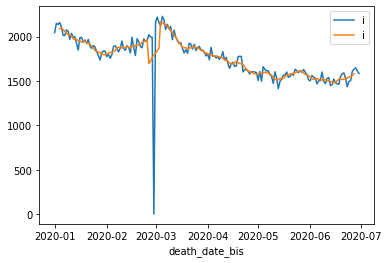

In [21]:
s2018=p2018[["death_date_bis","i"]][(p2018["death_date_bis"]>=datetime.date(2020,1,1))&\
                        (p2018["death_date_bis"]<datetime.date(2020,7,1))].groupby('death_date_bis').sum()
ax=s2018.plot()
s2018.rolling(7,center=True).mean().plot(ax=ax)

In [33]:
pc2=pc.set_index('date')[["cases"]].rolling(7,center=True).mean().reset_index()

Text(0.5, 1.0, 'Avec fenêtre glissante de 7 jours centrée ')

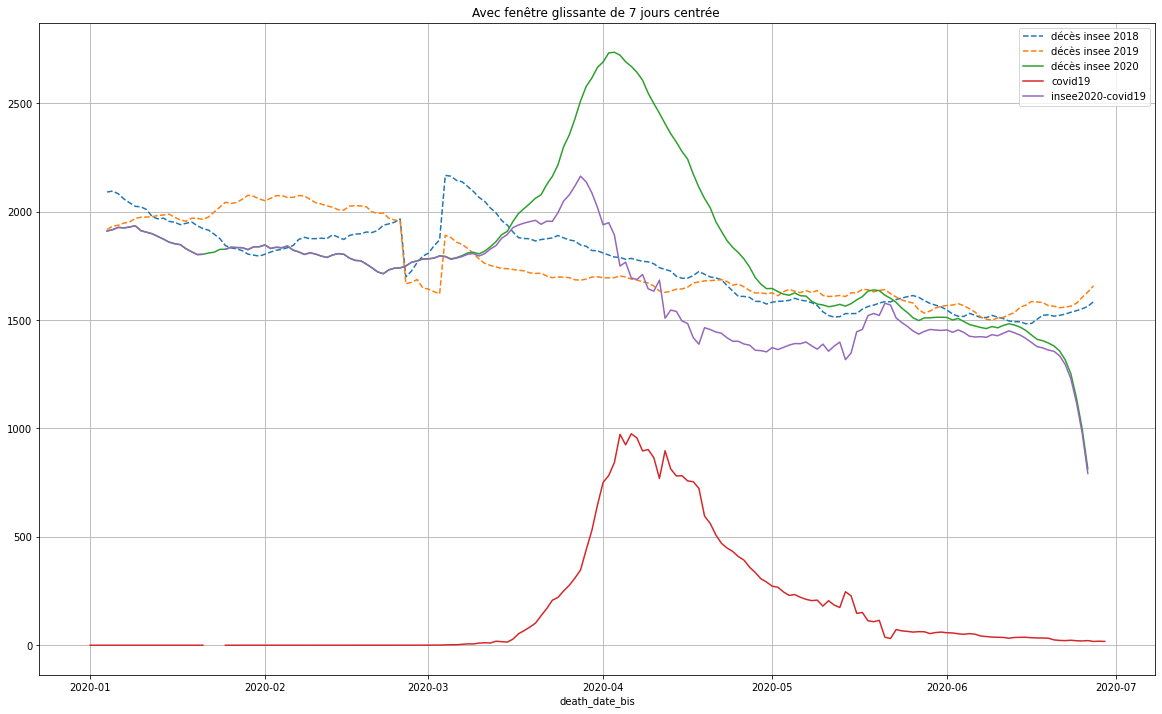

In [39]:
ax=p2018[["death_date_bis","i"]][(p2018["death_date_bis"]>=datetime.date(2020,1,1))&\
                        (p2018["death_date_bis"]<datetime.date(2020,7,1))].groupby('death_date_bis').sum().rolling(7,center=True).mean().plot(figsize=(20,12),style=['--'])
plt.legend(['décès 2018'])
p2019[["death_date_bis","i"]][(p2019["death_date_bis"]>=datetime.date(2020,1,1))&\
                        (p2019["death_date_bis"]<datetime.date(2020,7,1))].groupby('death_date_bis').sum().rolling(7,center=True).mean().plot(ax=ax,style=['--'])
plt.legend(['décès 2019'])
s2020=p2020[["death_date_bis","i"]][(p2020["death_date_bis"]>=datetime.date(2020,1,1))&\
                        (p2020["death_date_bis"]<datetime.date(2020,7,1))].groupby('death_date_bis').sum().rolling(7,center=True).mean()
v=[]
for k in s2020.reset_index()["death_date_bis"]:
    if k in pc2["date"].to_list():
        v.append(pc2[pc2["date"]==k.isoformat()]["cases"].to_list()[0])
    else:
        v.append(0)
s2020["covid19"]=v
s2020["insee - covid19"]=s2020["i"]-s2020["covid19"]
s2020.plot(ax=ax)
plt.legend(['décès insee 2018','décès insee 2019','décès insee 2020','covid19','insee2020-covid19'])
plt.grid()
plt.title('Avec fenêtre glissante de 7 jours centrée ')

In [174]:
v=[]
for k in p2020[["death_date_bis","i"]][(p2020["death_date_bis"]>=datetime.date(2020,1,1))&\
                        (p2020["death_date_bis"]<datetime.date(2020,7,1))].groupby('death_date_bis').sum().reset_index()["death_date_bis"]:
    if k in pc["date"].to_list():
        v.append(pc[pc["date"]==k.isoformat()]["cases"])
    else:
        v.append(0)

In [177]:
s2020

,i
death_date_bis,
2020-01-01,1915
2020-01-02,1906
2020-01-03,1963
2020-01-04,1842
2020-01-05,1756
...,...
2020-06-25,1140
2020-06-26,893
2020-06-27,550


In [155]:
datetime.date(2020,3,3) in pc["date"].to_list()

True

In [173]:
pc[pc["date"]=="2020-03-03"]["cases"].to_list()[0]

1